**Neuro-AI: Harnessing AI to understand computation in mind and brain**  
**Day 3: Neural encoding, decoding & reconstruction with deep learning**  

# Neural encoding and decoding of multi-unit activity during visual perception in macaque visual cortex via GANs

In this tutorial, you will get hands-on experience with neural encoding and decoding using deep learning. For neural encoding, you'll use the discriminative features of VGG16, pretrained on the ImageNet dataset for object recognition. For neural decoding, you'll use generative $w$-latents of [StyleGAN-XL](https://github.com/autonomousvision/stylegan-xl), a model that has been pretrained for image generation based on ImageNet as done in ["Brain2GAN: Feature-disentangled neural encoding and decoding of visual perception in the primate brain"](https://doi.org/10.1371/journal.pcbi.1012058). As such, you will see how visual experiences can be recreated based on neural activity data.

This tutorial is structured in five sections:

1. StyleGAN-XL
2. The dataset
3. Feature extraction
4. Neural encoding
5. Neural decoding



##1. StyleGAN-XL

[A Generative Adversarial Network (GAN)](https://en.wikipedia.org/wiki/Generative_adversarial_network) is a type of generative model designed to create synthetic ("fake") data that closely resembles the ("real") data it is trained on (but also looks sufficiently different). It works by sampling a "latent" vector from a simple distribution (e.g., a Standard Gaussian), which is fed into the generator $G$ of the GAN. $G$ processes this input and output a new, realistic-looking image that resembles the data it is trained on.




### Getting started

1. Enable GPU via Runtime > Change runtime type > GPU.
2. Run the first three cells below to:
 1. Mount your Google Drive, so you can access your files and folders directly from this environment
 2. Create a new directory therein named "B2G".
3. Transfer the folders from [this Drive](https://drive.google.com/drive/folders/1ySfDyhL2mvyileL-u1KL9U31kEjxqgS-?usp=sharing) into your newly created "B2G" directory -- you will be needing them from section 2 on. Rather than downloading and re-uploading (filesizes are quite large so take much time and space), you can create shortcuts from your own Drive: right-click on each folder you need and select "Add shortcut to Drive."
3. Also run the cells 4 and 5 to clone the GitHub repository of StyleGAN-XL (this takes a while), and the functions `z_to_w()` and `w_to_image()`.

In [ ]:
# Mount your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import ast
import os
import pickle
import time

import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal
from torchvision import transforms
from sklearn.linear_model import RidgeCV, LinearRegression
from scipy import stats
from scipy.stats import t

import torch
import torch.nn.functional as F

In [ ]:
# Create your working directory "B2G"
my_dir = "/content/drive/My Drive/B2G"
if not os.path.exists(my_dir):
    os.makedirs(my_dir)
    print("Directory B2G created.")
else:
    print("Directory B2G already exists.")

Directory B2G already exists.


In [ ]:
! git clone https://github.com/autonomousvision/stylegan_xl.git
! pip install timm==0.6.13 ftfy einops ninja dill
! wget -c "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet512.pkl"

import sys
sys.path.append('./stylegan_xl')

import dnnlib
import legacy

# Load the GAN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with dnnlib.util.open_url("imagenet512.pkl") as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Cloning into 'stylegan_xl'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 298 (delta 74), reused 51 (delta 51), pack-reused 209
Receiving objects: 100% (298/298), 13.88 MiB | 12.46 MiB/s, done.
Resolving deltas: 100% (141/141), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 21.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.w

In [ ]:
def z_to_w(G, z, device, truncation_psi=1.0, class_idx=None):
    """Generate class-conditional w-latents from z-latents using a StyleGAN-XL generator.

    Args:
        G (Generator model): The StyleGAN-XL generator with a "synthesis" network.
        z (torch.Tensor): The input latent vectors z (drawn from a normal distribution).
        device (torch.device): The device (e.g., 'cpu' or 'cuda') on which computations will be performed.
        truncation_psi (float, optional): The strength of the truncation trick to control the variation of the output.
            A value of 1.0 means no truncation. Defaults to 1.0.
        class_idx (int, optional): An optional class index for conditional generation. If provided, all samples
            will be conditioned on this class index. If None, class indices will be randomly sampled.

    Returns:
        torch.Tensor: The output w-latents, adjusted by the truncation trick if applicable.
    """

    # Handle conditional generation
    if G.c_dim != 0:
        if class_idx is None:
            # Sample random class indices if no specific class is given
            class_indices = rng.randint(low=0, high=G.c_dim, size=z.shape[0])
        else:
            # Use provided class index
            class_indices = np.full(z.shape[0], class_idx)
        class_indices = torch.from_numpy(class_indices).to(device)
        labels = F.one_hot(class_indices, num_classes=G.c_dim)
        w_avg = G.mapping.w_avg.index_select(0, class_indices)
    else:
        w_avg = G.mapping.w_avg.unsqueeze(0)
        labels = None
        if class_idx is not None:
            print('Warning: Class index is ignored when running an unconditional model.')

    # Mapping z to w
    w = G.mapping(z, labels)

    # Apply the truncation trick
    w_avg = w_avg.unsqueeze(1).repeat(1, G.mapping.num_ws, 1)
    w = w_avg + (w - w_avg) * truncation_psi
    return w


def w_to_image(G, w):
    """Generate an image from w-latents using the StyleGAN-XL generator.

    Args:
        G (Generator model): The StyleGAN-XL generator with a "synthesis" network.
        w (torch.Tensor): A single w-latent vector used to generate an image. The
                    tensor should be of the shape appropriate for the generator's
                    input, typically (1, 37, 512).

    Returns:
        PIL.Image: The generated image from the provided latents.
    """
    img = G.synthesis(w, noise_mode="none")
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img = Image.fromarray(img[0].cpu().numpy(), 'RGB')
    return img

### Exercise 1

In StyleGAN-XL, the initial step in generating images involves transforming a
$z$-latent vector into a $w$-latent vector. The $z$-latent is sampled from a normal distribution (a Gaussian distribution with zero mean and unit variance) which ensures that the $z$-latent vectors are diverse, contributing to the variability in the generated images.

This $z$-latent is then passed through a mapping network, typically comprising several fully connected layers, which converts it into the $w$-latent. The primary goal of this transformation is to _disentangle_ the latent space representation. As such, the latent features that represent different visual features get disentangled. For instance, in a $z$-latent, manipulating a single feature might simultaneously change both the color and shape of an object in the image. In contrast, in a $w$-latent, one feature might control only the color, while another controls only the shape.

- Sample a bunch of $z$-latents from a Standard Gaussian distribution of shape $(batch\_size, 64)$.
- Feed the $z$-latents to `z_to_w()` to get the $w$-latents of shape $(batch\_size, 37, 512)$ (note that the second axis contains 37 copies of the 512-dimensional latent). Ensure that your input is formatted as a PyTorch tensor, and that it is transferred to the GPU by appending `.to(device)` to your tensor.
- Feed $G$ and the $w$-latents to `w_to_image()` to reconstruct the corresponding images, and visualize these images.

ToThink 1: What does it mean for a model's latent space to be "feature-disentangled"? Why is it beneficial for a generative model's latent space to be feature-disentangled?

In [ ]:
### your code here

##### answer

Setting up PyTorch plugin "bias_act_plugin"... 

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... 

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


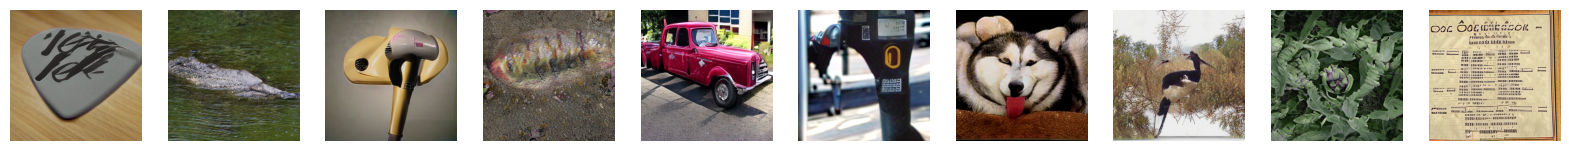

In [ ]:
batch_size = 10
rng = np.random.RandomState(8888)
z_samples = rng.randn(batch_size, G.z_dim)
w_samples = z_to_w(G,
                   torch.from_numpy(z_samples).to(device),
                   device)

plt.figure(figsize=(batch_size * 2, 2))
for i in range(batch_size):
    img = w_to_image(G, w_samples[i, None])
    plt.subplot(1, batch_size, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


# ToThink 1: feature-disentangled means that changes in one visual feature (e.g.,
# "smile" in a face image) does not affect the other visual features (e.g., age,
# hair color, hair style, lighting etc.). This disentanglement of visual features
# enhances the model's ability to generate images where specific attributes can be
# independently modified.

# Benefits: interpretability and controllability of the model (precize manipulation
# of output via manipulation of the latents), more stable training by minimizing
# the overlap of features (predictable changes during model updates).

### Exercise 2

Run the cell below to see which class indices correspond to which class labels. Subsequently, play around with the following parameters of `z_to_w()`:

- `class_idx`
- `truncation_psi`

ToThink 2: How does `truncation_psi` influence the generated images; what is the "truncation trick"?

In [ ]:
from itertools import islice


with open('stylegan_xl/media/imagenet_idx2labels.txt') as f:
    d1 = f.read()
d1 = ast.literal_eval(d1)

# # 1000 categories, print first n
n = 5
for k, v in islice(d1.items(), n):
    print(k, v)

0 tench, Tinca tinca
1 goldfish, Carassius auratus
2 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
3 tiger shark, Galeocerdo cuvieri
4 hammerhead, hammerhead shark


In [ ]:
### your code here

##### answer

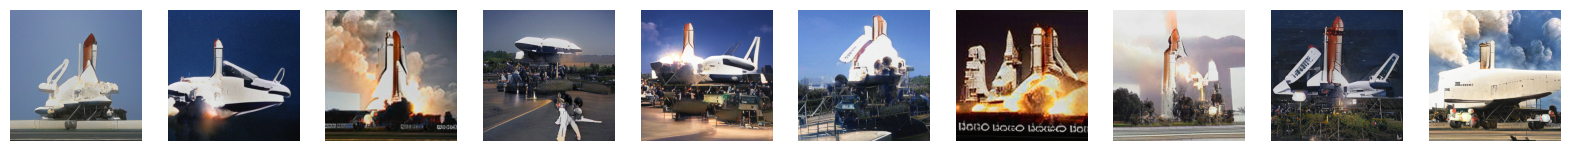

In [ ]:
# Class images
batch_size = 10
class_idx = 812
truncation_psi=0.8
rng = np.random.RandomState(8888)
z_samples = rng.randn(batch_size, G.z_dim)                                                       # Shape = (10, 64)
w_samples = z_to_w(G,
                   torch.from_numpy(z_samples).to(device),
                   device,
                   class_idx=class_idx,
                   truncation_psi=truncation_psi)

plt.figure(figsize=(batch_size * 2, 2))
for i in range(batch_size):
    img = w_to_image(G, w_samples[i, None])
    plt.subplot(1, batch_size, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


# ToThink 2: The truncation_psi parameter adjusts the vectors towards the mean of
# the latent space distribution. Lower truncation_psi values result in more
# realistic-looking outputs (resembling the "average" training data) but also
# reduces the diversity in the latents that are fed into the generator.

### Exercise 3

Linear interpolation between two latents involves calculating a sequence of intermediate latents that gradually shift from the first latent vector to the second latent vector. This is done by computing a weighted combination of the two vectors at each step, where the weights adjust progressively from favoring the first vector to favoring the second. If you generate the images that correspond to the resulting intermediate latents, you will see a smooth transition from the first to the second image. For instance, if the first image is a face of a young person and the second of an old person, linear interpolation will show a progressive aging effect.

Implement linear interpolation between two w-latents (originally derived from z-latents):

$(1 - n\_steps) * w1 + n\_steps * w2$

1. Randomly generate two z-latents and transform them into w-latents.
2. Generate a `ratios` tensor of `n_steps` evenly spaced points between 0 and 1, for instance using `torch.linspace`. These points represent the proportion of contribution from one $w$-latent as opposed to the other at each step of the interpolation.
3. Weigh the two $w$-latents using `ratios`, resulting in `n_steps` $w$-latents.
4. Feed the resulting $w$-latents to the generator, and visualize the images next to one another.

ToThink 3: How would truncation influence the outcomes of interpolating between latent vectors? What are the potential benefits or drawbacks of applying truncation during this process?

In [ ]:
### your code here

##### answer

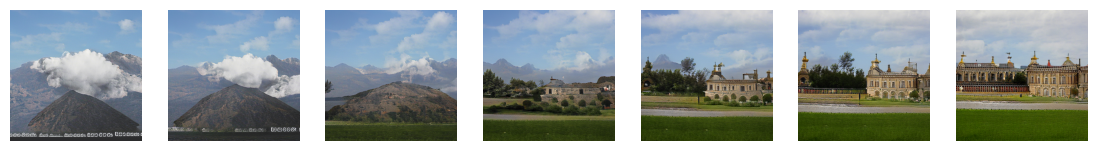

In [ ]:
def interpolate(a, b, steps=10):
    ratios = torch.linspace(0, 1, steps=steps, device=device)
    interpolated = torch.lerp(w1, w2, ratios.unsqueeze(1).unsqueeze(1))
    return interpolated

# Generate two sample z-latents
# rng = np.random.RandomState(8888)
# z1 = torch.randn(1, G.z_dim, device=device)
# z2 = torch.randn(1, G.z_dim, device=device)
z1 = rng.randn(1, G.z_dim)
z2 = rng.randn(1, G.z_dim)
w1 = z_to_w(G, torch.from_numpy(z1).to(device), device, truncation_psi=0.7, class_idx=980)
w2 = z_to_w(G, torch.from_numpy(z2).to(device), device, truncation_psi=0.7, class_idx=698)
w_interp = interpolate(w1, w2, steps=7)

# Generate images from interpolated w-latents
plt.figure(figsize=(batch_size * 2, 2))
for i in range(len(w_interp)):
    img = w_to_image(G, w_interp[i, None])
    plt.subplot(1, batch_size, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


# ToThink 3: The use of truncation in interpolating between latent vectors
# is a trade-off between fidelity and diversity. During interpolation, truncation
# ensures that the transitions between images are smoother and less abrupt. This
# is because the extreme values in the latent vectors, which could lead to sudden
# changes in image characteristics, are clipped. A drawback is less diversity.

## 2. The dataset

The dataset contains GAN-generated visual stimuli and corresponding brain responses recorded from a macaque with cortical implants while it was looking at the images. The brain data consists of multi-unit activity (MUA) from 15 microelectrode arrays: 7 arrays in V1, 4 arrays in V4 and 4 arrays in IT. Each array consists 64 microelectrode channels, resulting in 960 recordings in total. These regions are part of the ventral visual stream for object recognition in the brain -- often referred to as the "what" pathway because it processes information about what objects are seen. Importantly, as visual information flows from V1 to IT, the neural representations become increasingly abstract and complex.

### Exercise 4

1. The folder `StyleGAN_XL_w.pickle` with the $w$-latents underlying the visual stimuli from the Brain2GAN dataset should be accessible from your B2G directory (else, you can also download them manually from [this link](https://figshare.com/articles/dataset/Brain2GAN_StyleGAN-XL_/25637856) and wait until it is properly uploaded to avoid errors.)
2. Confirm that it contains 200 and 4000 test and training latents, respectively.
3. Generate the test images. Use the generator of StyleGAN-XL to synthesize the test images from `w_te`. Note that the latents were saved as numpy arrays with only a single copy for efficiency (shape (batch, 512)). You will need to convert them to PyTorch arrays and expand each latent by repeating it 37 times along the second axis to match the input requirements, and have shape (batch, 37, 512):

    `w = torch.from_numpy(w).float().to(device).unsqueeze(1).repeat(1, 37, 1)`

4. Save the images. Store the visual stimuli in the "Test" folder.
5. You already put the Training folder with the training stimuli in your B2G directory (alternatively, you could also generate them yourself from `w_tr`, but this takes ~30 min and considerable GPU resources whereas you don't have unlimited access).
6. Visualize a bunch of test and training images.


In [ ]:
with open("/content/drive/My Drive/B2G/StyleGAN_XL_w.pickle", "rb") as handle:
    w = pickle.load(handle)
w_te = w["test"]
w_tr = w["train"]
w_te.shape, w_tr.shape

((200, 512), (4000, 512))

In [ ]:
### your code here

##### answer

In [ ]:
for folder in ["Test", "Reconstruction"]:
    if not os.path.exists(os.path.join("/content/drive/My Drive/B2G", folder)):
        os.makedirs(os.path.join("/content/drive/My Drive/B2G", folder))

# test
_w_te = torch.from_numpy(w_te).float().to(device).unsqueeze(1).repeat(1, 37, 1)
for i in range(len(_w_te)):
    img = w_to_image(G, torch.tensor(_w_te[i, None]).float())
    img.save(f"/content/drive/My Drive/B2G/Test/{str(i+1).zfill(4)}.png")

# # training
# _w_tr = torch.from_numpy(w_tr).float().to(device).unsqueeze(1).repeat(1, 37, 1)
# for i in range(len(_w_tr)):
#     img = w_to_image(G, torch.tensor(_w_tr[i, None]).float())
#     img.save(f"/content/Training/{str(i+1).zfill(4)}.png")

<ipython-input-15-516f625dc668>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = w_to_image(G, torch.tensor(_w_te[i, None]).float())


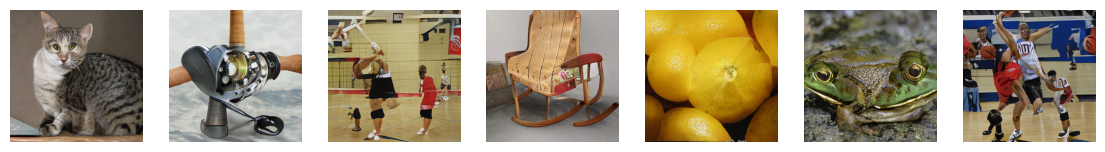

In [ ]:
# Visualize a bunch
batch_size = 7
plt.figure(figsize=(batch_size * 2, 2))
for i in range(batch_size):
    img = Image.open(f"/content/drive/My Drive/B2G/Test/{str(i+1).zfill(4)}.png")
    plt.subplot(1, batch_size, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

### Exercise 5

1. The folder `StyleGAN_XL_MUA.mat` with the brain responses of the Brain2GAN dataset should be accessible from your B2G directory (else, you can also download them manually from [this link](https://figshare.com/articles/dataset/Brain2GAN_StyleGAN-XL_/25637856) and wait until it is properly uploaded to avoid errors.)
2. Run the cell below to load the MUA data from the Brain2GAN dataset. Verify that it contains 200 and 4000 test and training responses, respectively, with each response consisting of recordings from 960 microelectrode channels. Note that one microelectrode array is deleted because it was broken, leaving data from 15 functioning arrays; originally it was 16 arrays.
2. Visualize your brain data in some shape or form. For instance, by plotting the responses of some individual examples or by plotting the mean and standard deviation of each microelectrode channel in the training and test set. Because it is good practice to look at your data.

In [ ]:
f1 = h5py.File("/content/drive/My Drive/B2G/StyleGAN_XL_MUA.mat", "r")
x_te = np.delete(np.array(f1["test_MUA"]), np.arange(320, 384), axis=1)
x_tr = np.delete(np.array(f1["train_MUA"]), np.arange(320, 384), axis=1)
x_te.shape, x_tr.shape

((200, 960), (4000, 960))

In [ ]:
### your code here

##### answer

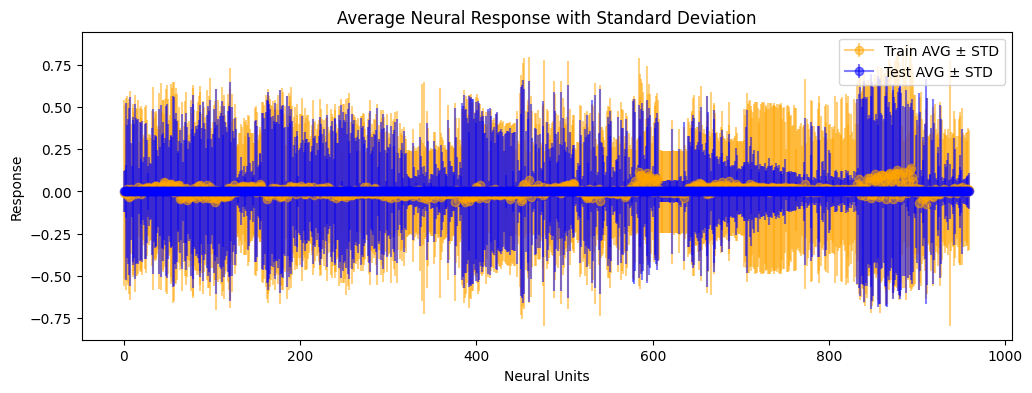

In [ ]:
# Visualize these responses in some way
mu_te = np.mean(x_te, axis=0)
mu_tr = np.mean(x_tr, axis=0)
sd_tr = np.std(x_tr, axis=0)
sd_te = np.std(x_te, axis=0)

plt.figure(figsize=(12, 4))
plt.errorbar(range(len(mu_tr)), mu_tr, yerr=sd_tr, label='Train AVG ± STD', fmt='-o', color='orange', alpha=0.5)
plt.errorbar(range(len(mu_te)), mu_te, yerr=sd_te, label='Test AVG ± STD', fmt='-o', color='blue', alpha=0.5)
plt.title('Average Neural Response with Standard Deviation')
plt.xlabel('Neural Units')
plt.ylabel('Response')
plt.legend()
plt.show()

## 3. Feature extraction

Run the two cells below to:

1. In your B2G directory, create an empty directory named "Test_Features" in which you will store the features extracted from the test stimuli. Note that you already uploaded the features from the training stimuli to the working directory (note that you could extract the training features yourself, but this is very time-intensive and consumes considerable GPU resources while your account does not provide unlimited GPU access).
2. Load in the VGG16 network pretrained on object recognition for feature extraction at five different layers. This methodology leverages the hierarchical architecture of VGG16, where each layer captures features of increasing complexity. Starting with low-level features such as edges and textures in the early layers, the model progresses to high-level features like object parts and entire objects in deeper layers.

In [ ]:
# Create an empty directory "Test_Features" in your working directory
if not os.path.exists(os.path.join("/content/drive/My Drive/B2G", "Test_Features")):
    os.makedirs(os.path.join("/content/drive/My Drive/B2G", "Test_Features"))

In [ ]:
class Model:
    """
    A model wrapper for feature extraction using pre-trained models from PyTorch's model hub.

    Attributes:
        model (torch.nn.Module): A PyTorch model loaded and set to evaluation mode.
        preprocess (torchvision.transforms.Compose): A preprocessing pipeline that
            standardizes input images before they are fed into the model.

    Args:
        model (str): The name of the model to load from PyTorch's hub (e.g., 'vgg16').
        weights (torchvision.models.PretrainedWeights): The pre-trained weights to use.
    """
    def __init__(self, model, weights):
        self.model = torch.hub.load('pytorch/vision:v0.10.0', model, weights=weights).eval().to('cuda')
        self.preprocess = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def get_features(self, index, layer, folder, batch_size, n, start=0):
        output = []
        for i in range(start + batch_size * n, start + batch_size * (n + 1)):
            input_image = Image.open("/content/drive/My Drive/B2G/%s/%s.png" % (folder, str(i+1).zfill(4)))
            input_tensor = self.preprocess(input_image).unsqueeze(0).to('cuda')
            _out = self.model.features[:layer](input_tensor).detach().cpu().numpy()
            if index < 2:
                _out = downsample(_out, index)
            output.append(_out)
        return np.array(output).squeeze()


def kernel(n):
    """
    Generates a Gaussian kernel used for convolution.

    Args:
        n (int): The size of the kernel (n x n).

    Returns:
        numpy.ndarray: A 2D Gaussian kernel. This kernel is used to apply a Gaussian
                       blur to an image or feature map.
    """
    x, y = np.meshgrid(np.linspace(-1, 1, n), np.linspace(-1, 1, n))
    dst = np.sqrt(x*x + y*y)
    sigma = 1
    muu = 0.000
    return np.exp(-((dst-muu) ** 2 / ( 2.0 * sigma**2)))


def downsample(filters, layer):
    """
    Downsamples feature maps by applying a Gaussian convolution and then sub-sampling.

    Args:
        filters (numpy.ndarray): The input feature maps to downsample, expected in the
                                 format [1, num_filters, height, width].
        layer (int): The index indicating which down-sampling stride to use from the
                     predefined list `ds = [56, 28]`. `layer` should be 0 or 1.

    Returns:
        numpy.ndarray: The downsampled feature maps. The shape of the output is adjusted
                       according to the down-sampling rate defined by the `ds` list, where
                       each feature map is convolved with a Gaussian kernel and then
                       sub-sampled by taking every second element.
    """
    ds = [56, 28]
    result = np.zeros((filters.shape[1], ds[layer], ds[layer]))
    for filter in range(filters.shape[1]):
        result[filter] = signal.convolve(filters[0, filter], kernel(2), mode="same")[::2, ::2]
    return result[None]


# Load the discriminative model for feature extraction
vgg_model = Model("vgg16", "VGG16_Weights.DEFAULT")

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 205MB/s]


In [ ]:
# Look at the model architecture
vgg_model

### Exercise 6

You will extract features at five different depths of the network, scale these features to the range (0, 255) and convert from `float64` to `uint8` for memory efficiency, and save them in the specified directory. Save the min and max to later convert them back again from `uint8` to `float64` or `float32`. Specifically, we will extract each feature activation after max pooling, which correspond to layers 5, 10, 17, 24 and 31.

In the cell below, we already initialized the feature arrays with the proper shapes (e.g., the first layer activations of VGG16 (layer=5, index=0) have shape (1, 64, 56, 56) for one image, note that we extract features from 200 test images, hence the shape (200, 64, 56, 56)), and an additional array to store the minimum and maximum values of the features for each layer, which will be used later to scale back to dtype `float`.

1. Write a for-loop over the five layers, and extract their features in batches (it cannot handle all 200 test examples in one go, so instead process 4 times a batch of 50 images at a time) using the predefined function `vgg_model.get_features()` to extract features for each batch. For instance, layer=5; index=0; batch_size=50:

        for batch in range(4):
           feature = vgg_model.get_features(0, 5, "Test", batch_size=50, n=batch)

2. calculate the minimum and maximum values of the features. Store these values in `minmax_te`.

3. Scale the extracted features to the range 0-255. This involves subtracting the minimum value of the features, dividing by the range (max-min), and then scaling to 255. Convert the scaled features to uint8 to reduce memory usage.

4. Assign the scaled features to the corresponding position in the features arrays.

5. Save each feature array in the `/content/drive/My Drive/B2G/Test_Features/` directory.

6. Also, save `minmax_te` which holds the scaling factors used for each layer.

ToThink 4: How does the complexity of the extracted features change as you move from the initial layers to the deeper layers of the network?

In [ ]:
# These layer correspond to index = [0, 1, 2, 3, 4], respectively
layers = [5, 10, 17, 24, 31]

# Initialize feature arrays of the correct shapes
vgg_t1 = np.zeros((200, 64, 56, 56), dtype=np.uint8)  # downsampled: 112 -> 56
vgg_t2 = np.zeros((200, 128, 28, 28), dtype=np.uint8) # downsampled: 56 -> 28
vgg_t3 = np.zeros((200, 256, 28, 28), dtype=np.uint8)
vgg_t4 = np.zeros((200, 512, 14, 14), dtype=np.uint8)
vgg_t5 = np.zeros((200, 512, 7, 7), dtype=np.uint8)
minmax_te = np.zeros((5, 2))

In [ ]:
### your code here

##### answer

In [ ]:
# VGG16 for object recognition
batch_size = 50

# test set features
vgg_t1 = np.zeros((200, 64, 56, 56), dtype=np.uint8)  # ds: 112 -> 56
vgg_t2 = np.zeros((200, 128, 28, 28), dtype=np.uint8) # ds: 56 -> 28
vgg_t3 = np.zeros((200, 256, 28, 28), dtype=np.uint8)
vgg_t4 = np.zeros((200, 512, 14, 14), dtype=np.uint8)
vgg_t5 = np.zeros((200, 512, 7, 7), dtype=np.uint8)
vgg = [vgg_t1, vgg_t2, vgg_t3, vgg_t4, vgg_t5]
minmax_te = np.zeros((5, 2))
for i, layer in enumerate(layers):
    for n in range(4):
        f = vgg_model.get_features(i, layer, "Test", batch_size=batch_size, n=n)
        minmax_te[i, 0] = f.min()
        minmax_te[i, 1] = f.max()
        scaled_f = ((f - minmax_te[i, 0]) / (minmax_te[i, 1] - minmax_te[i, 0]) * 255).astype(np.uint8)
        vgg[i][n*batch_size:(n+1)*batch_size] = scaled_f
    np.save("/content/drive/My Drive/B2G/Test_Features/vgg_te_%i.npy" % i, vgg[i])
np.save("/content/drive/My Drive/B2G/Test_Features/minmax.npy", minmax_te)

# # training set features
# vgg_t1 = np.zeros((4000, 64, 56, 56))
# vgg_t2 = np.zeros((4000, 128, 28, 28))
# vgg_t3 = np.zeros((4000, 256, 28, 28))
# vgg_t4 = np.zeros((4000, 512, 14, 14))
# vgg_t5 = np.zeros((4000, 512, 7, 7))
# vgg = [vgg_t1, vgg_t2, vgg_t3, vgg_t4, vgg_t5]
# for i, layer in enumerate(layers):
#     for n in range(80):
#         vgg[i][n*batch_size:(n+1)*batch_size] = vgg_model.get_features(i, layer, "Training", batch_size=batch_size, n=n)
#     np.save("/content/Training_Features/vgg_tr_%i.npy" % i, vgg[i])


# ToThink 4: Increasing complexity; initial Layers capture simple features of the
# input image (e.g., edges, colors, and textures), whereas deeper layers represent
# higher-level features (e.g., from textures to object parts to whole objects).
# Earlier layers are closer to the input image itself, whereas deeper layers are
# closer to the abstracted representation thereof that is used for object recognition
# by VGG16

## 4. Neural encoding

Implement neural encoding models to predict brain responses from features extracted using the VGG16 network.

This section of the tutorial does not require GPU resources, so you can disable the GPU to conserve your computational resources. Please be aware that this will reset your current session, resulting in the loss of all unsaved variables. Ensure that you have saved all necessary data and outputs to the "B2G" folder on your drive before proceeding.

### Exercise 7

1. Load the previously saved features and their corresponding min-max values from the training and test set. [!!] Important: In case of memory errors, use a subset of $n$ random (but without replacement) training examples. Increasing $n$ enhances the signal but requires more memory.

2. Convert the test and training features from uint8 back to their float scale using the saved min-max values. Specifically:

$feature_{float} = feature_{int} \times (\frac{max - min}{255}) + min$
  
2. Fit a Ridge regression model (you can use scikitlearn's RidgeCV) for each layer of features with a range of strong (!!) regularization coefficients to control for overfitting.

ToThink5: Which regularization coefficient was optimal for each layer?

3. Predict the 200 test responses using the fitted model on the test set features, and save these predictions.


In [ ]:
### your code here

##### answer

In [ ]:
tr_n = 1000
tr_idx = np.random.permutation(4000)[:tr_n]
vgg_t1 = np.zeros((n, 64, 56, 56), dtype=np.uint8)  # ds: 112 -> 56
vgg_t2 = np.zeros((n, 128, 28, 28), dtype=np.uint8) # ds: 56 -> 28
vgg_t3 = np.zeros((n, 256, 28, 28), dtype=np.uint8)
vgg_t4 = np.zeros((n, 512, 14, 14), dtype=np.uint8)
vgg_t5 = np.zeros((n, 512, 7, 7), dtype=np.uint8)
vgg_tr = [vgg_t1, vgg_t2, vgg_t3, vgg_t4, vgg_t5]

minmax_tr = np.load("/content/drive/My Drive/B2G/Training_Features/minmax.npy")
for layer in range(5):
    vgg_tr[layer] = np.load(f"/content/drive/My Drive/B2G/Training_Features/vgg_tr_{layer}_asuint8.npy")[tr_idx]
    vgg_tr[layer] = (vgg_tr[layer].astype(np.float32) / 255) * (minmax_tr[layer, 1] - minmax_tr[layer, 0]) + minmax_tr[layer, 0]

In [ ]:
vgg_t1 = np.zeros((200, 64, 56, 56), dtype=np.uint8)  # ds: 112 -> 56
vgg_t2 = np.zeros((200, 128, 28, 28), dtype=np.uint8) # ds: 56 -> 28
vgg_t3 = np.zeros((200, 256, 28, 28), dtype=np.uint8)
vgg_t4 = np.zeros((200, 512, 14, 14), dtype=np.uint8)
vgg_t5 = np.zeros((200, 512, 7, 7), dtype=np.uint8)
vgg_te = [vgg_t1, vgg_t2, vgg_t3, vgg_t4, vgg_t5]

minmax_te = np.load("/content/drive/My Drive/B2G/Test_Features/minmax.npy")
for layer in range(5):
    vgg_te[layer] = np.load(f"/content/drive/My Drive/B2G/Test_Features/vgg_te_{layer}.npy")
    vgg_te[layer] = (vgg_te[layer].astype(np.float32) / 255) * (minmax_te[layer, 1] - minmax_te[layer, 0]) + minmax_te[layer, 0]

In [ ]:
for layer in range(5):
    model = RidgeCV(alphas=[1000, 10000, 100000, 1000000, 10000000]).fit(vgg_tr[layer].astype(np.float32).reshape(tr_n, -1), x_tr[tr_idx])
    print(layer, model.alpha_)
    np.save(f"/content/y_{layer}.npy", model.predict(vgg_te[layer].astype(np.float32).reshape(200, -1)))

# ToThink5:
# 0 1000000
# 1 1000000
# 2 1000000
# 3 1000000
# 4 100000

0 1000000
1 1000000
2 1000000
3 100000
4 100000


### Exercise 8

Explore feature-response relationships across the three visual areas V1, V4 and IT. Your analysis will focus on evaluating prediction performance using Pearson correlation coefficients and visualizing the distribution of these performances across the five layers of the model.

1. Data slicing and correlation analysis. Segment x_tr and x_te to isolate the responses corresponding to three distinct brain regions:
- V1: Indices 0 to 447
- V4: Indices 448 to 703
- IT: Indices 704 to 959

  For each of the five layers, calculate the Pearson correlation coefficient between the predicted responses (`y`) and the actual test set responses (`x_te`).

2. Layer assignment. For each microelectrode, determine the layer whose features resulted in the highest correlation coefficient. Assign this layer to that microelectrode.

3. Count occurences and plot them. For each brain area, count how often a layer was assigned to the microelectrodes therein. Use Matplotlib to plot a bar chart for each brain region. The X-axis should represent the layers (Layer 1-5), and the Y-axis should show the number of electrodes to which the layer was assigned. Ensure the percentage is normalized by the total number of electrodes in each region.

ToThink 6: Observing the distribution of layer assignments across visual areas suggests a pattern in how the neural network’s features align with brain responses. What is this pattern, and what might this tell us about the neural network's ability to model functional organization and processing hierarchies similar to those in the brain?


In [ ]:
def pearson_correlation_coefficient(x: np.ndarray, y: np.ndarray, axis: int) -> np.ndarray:
    r = (np.nan_to_num(stats.zscore(x)) * np.nan_to_num(stats.zscore(y))).mean(axis)
    p = 2 * t.sf(np.abs(r / np.sqrt((1 - r ** 2) / (x.shape[0] - 2))), x.shape[0] - 2)
    return r, p

In [ ]:
### your code here

##### answer

0 [35.94 29.24 33.04  0.67  1.12]
1 [18.75 11.33 28.12 25.39 16.41]
2 [ 5.86  7.03  1.95 25.   60.16]


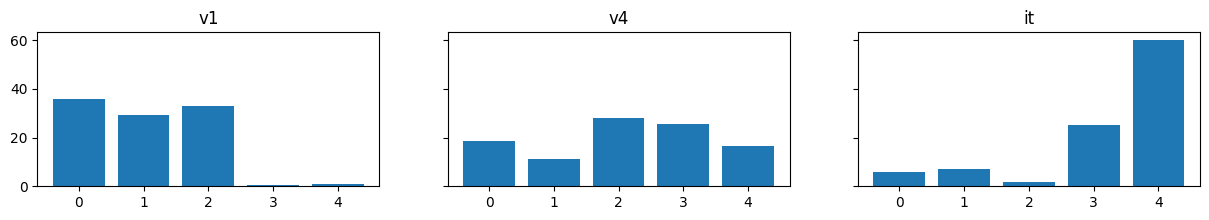

In [ ]:
ys = []
for layer in range(5):
    ys += [np.load(f"/content/y_{layer}.npy")]
rs_v1 = np.zeros((2, len(ys), 448))
rs_v4 = np.zeros((2, len(ys), 256))
rs_it = np.zeros((2, len(ys), 256))
_rs = [rs_v1, rs_v4, rs_it]
dims = [0, 448, 704, 960]
for index, y in enumerate(ys):
    for roi in range(3):
        r, p = pearson_correlation_coefficient(y[:, dims[roi]:dims[roi+1]], x_te[:, dims[roi]:dims[roi+1]], 0)
        _rs[roi][0, index] = r
        _rs[roi][1, index] = p


norm = [448, 256, 256]
rois = ["all", "v1", "v4", "it"]
fig, axs = plt.subplots(1, 3, figsize=(15, 2), sharey=True)
for roi in range(3):
    values, counts = np.unique(np.argmax(_rs[roi][0], axis=0), return_counts=True)
    _values = np.zeros(len(ys))
    _values[values] = counts
    print(roi, np.round(_values / norm[roi] * 100, 2))
    axs[roi].bar(range(len(_values)), _values / norm[roi] * 100)
    axs[roi].set_title(rois[roi+1])
plt.show()


# ToThink 5: the pattern is that lower layers are assigned to low-level visual area
# V1, mid-level layers to V4 and high-level layer to high-level area IT. That is,
# just like the ventral visual stream, a complexity gradient also emerged in the
# neural network based on the training on object recognition. As such, we could
# use these models to study the brain.

## 5. Neural decoding

### Exercise 9

Implement a neural decoding model to predict $w$-latents from brain responses. $w$-latents are not so large as the discriminative features from VGG16, so you can use all 4000 examples.

1. Fit a linear regression model on `x_tr` and `w_tr`
2. Predict the $w$-latents from `x_te`
3. Feed these predicted $w$-latents to the generator to reconstruct the corresponding images. Make sure to re-enable GPU and also expand the latents by repeating it 37 times along the second axis to match the input requirements of the generator.

ToThink 7: we saw earlier that we could set `truncation_psi` closer to 0 for higher fidelity. For decoding, what would we want this variable to be? And why?



In [ ]:
# Create an empty directory "Test_Features" in your working directory
if not os.path.exists(os.path.join("/content/drive/My Drive/B2G", "Reconstruction")):
    os.makedirs(os.path.join("/content/drive/My Drive/B2G", "Reconstruction"))

In [ ]:
### Your code here

##### answer

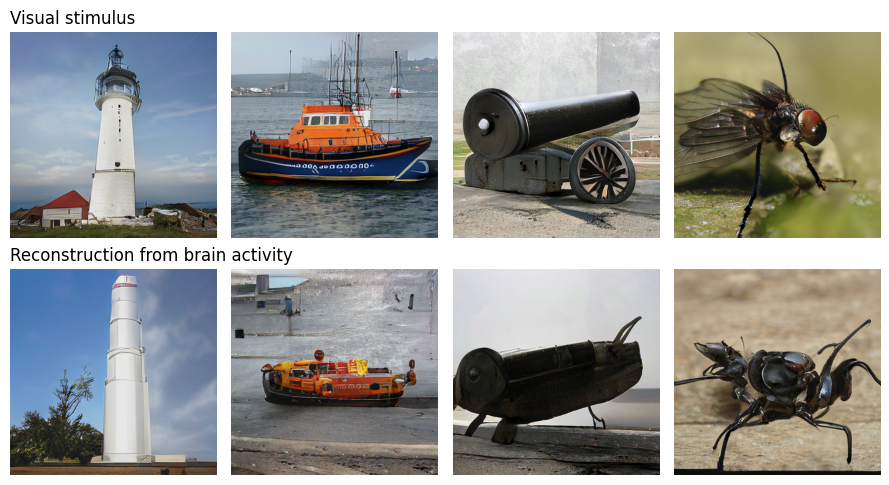

In [ ]:
reg = LinearRegression().fit(x_tr, w_tr)
y_te = reg.predict(x_te)

fig, axs = plt.subplots(2, 4, figsize=(9, 5))
_w_te = torch.from_numpy(np.repeat(w_te[:, None], 37, axis=1)).to(device)
_y_te = torch.from_numpy(np.repeat(y_te[:, None], 37, axis=1)).to(device)
for i, index in enumerate([93, 196, 80, 113]):
    axs[0, i].imshow(w_to_image(G, _w_te[index, None]))
    axs[0, i].axis("off")
    axs[0, 0].set_title("Visual stimulus", loc="left")
    axs[1, i].imshow(w_to_image(G, _y_te[index, None]))
    axs[1, i].axis("off")
    axs[1, 0].set_title("Reconstruction from brain activity", loc="left")
plt.tight_layout()
plt.show()

# ToThink 7: The `truncation_psi` parameter modifies the latent space by scaling
# it around its center. This scaling affects the diversity and realism of the
# generated images. So, setting truncation_psi closer to 0 constrains the model to
# generate images that are close to the "average" image. A higher truncation value,
# like 1.0, allows the model to use the full range of the latent space without
# restriction. Therefore, we set it to 1.0 so that the reconstructions faithfully
# represent the data-driven predictions rather than some average latent.

In [ ]:
_y_te = torch.from_numpy(y_te).float().to(device).unsqueeze(1).repeat(1, 37, 1)
for i in range(len(_y_te)):
    img = w_to_image(G, torch.tensor(_y_te[i, None]).float())
    img.save(f"/content/drive/My Drive/B2G/Reconstruction/{str(i+1).zfill(4)}.png")

<ipython-input-36-c9c8c99e9fcb>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = w_to_image(G, torch.tensor(_y_te[i, None]).float())



### Exercise 10

Quantify the reconstruction performance in terms of pixel similarity: the Pearson correlation coefficient between predicted and actual pixel values in the stimuli and reconstructions, respectively.

ToThink 8: what is the downside of this metric? Can you propose a more human-centric metric to assess reconstruction performance?


In [ ]:
### Your code here

##### answer

In [ ]:
i = 93
x = np.array(Image.open(f"/content/drive/My Drive/B2G/Test/{str(i+1).zfill(4)}.png")).flatten()
y = np.array(Image.open(f"/content/drive/My Drive/B2G/Reconstruction/{str(i+1).zfill(4)}.png")).flatten()
r, p = pearson_correlation_coefficient(x, y, 0)
r, p

# ToThink 8: Pixel correlation can be overly sensitive to exact alignment and intensity
# variations, which might not necessarily capture perceptual similarities recognized
# by human observers. A more human-centric metric is perceptual similarity: extract
# the features (for instance, of VGG16) from the stimulus and of the reconstructions
# and compare those rather the raw pixel values. These high-level features can offer
# an assessment that's closer to human judgement.

(0.47936507873098533, 0.0)

That's it!

**Bonus:** Implement the more human-centric metric from the previous exercise. You can use VGG16 for this end.